In [22]:
import numpy as np
import pandas as pd
from indigo import *
import matplotlib.pyplot as plt
pd.options.mode.chained_assignment = None  # default='warn'

from bokeh.io import output_notebook

In [23]:
output_notebook()

Loading BokehJS ...

### Some global variables used throughout this notebook

In [24]:
PATH = "Adrenergic_dataset.csv"
FOLDS = 5
SEED = 12
#ASSAY =  "AdrA1B_PCHEMBL_VALUE"
ASSAY =  "logP"

columns = ["Structure", "ID", ASSAY]

### Read data from csv

In [25]:
df = pd.read_csv(PATH)
df.head()

,Structure,ID,logP,Vx,MW,NegativeCharge,PositiveCharge,Flex,AromaticRings,OverallCharge,...,q485,frg-8,frg-26,frg-54,Nn,AdrA1A_PCHEMBL_VALUE,AdrA1B_PCHEMBL_VALUE,AdrA1D_PCHEMBL_VALUE,AdrA2A_PCHEMBL_VALUE,AdrA2C_PCHEMBL_VALUE
0,CC\C(=C(\CC)/c1ccc(O)cc1)\c2ccc(O)cc2,CHEMBL411,4.871,224.4,268.4,0,0,0.1905,2,0,...,4,2,0,0,0,NaN,NaN,NaN,NaN,5.66
1,CSc1ccc2Sc3ccccc3N(CCC4CCCCN4C)c2c1,CHEMBL479,5.900,290.2,370.6,0,2,0.1429,2,2,...,18,0,0,0,2,NaN,NaN,NaN,NaN,7.60
2,COc1cccc(CCN2C3C4C5CC6C7C5C3C7C2(O)C46)c1,CHEMBL2205811,3.040,225.5,309.4,0,1,0.1379,1,1,...,4,0,0,0,1,NaN,NaN,NaN,NaN,6.25
3,COc1cc(CN[C@H]2C3C4CC5C6C4CC3C6C25)cc(OC)c1OC,CHEMBL2432051,3.380,256.3,341.4,0,1,0.2000,1,1,...,8,0,0,0,1,NaN,NaN,NaN,NaN,5.64
4,COc1cccc(CCN2C3C4C5CC6C7C5C3C7C2(O)C46)c1OC,CHEMBL2205813,2.899,245.4,339.4,0,1,0.1613,1,1,...,6,0,0,0,1,NaN,NaN,NaN,NaN,5.36


### Drop NA values from assay value column

In [26]:
dataset = df[columns]
dataset.dropna(subset=[ASSAY], inplace=True)

In [27]:
indigo = Indigo()


def get_fingerprints(dataset: pd.DataFrame):
    indigo.setOption("ignore-stereochemistry-errors", True)
    indigo.setOption("ignore-bad-valence", True)
    indigo.setOption("similarity-type", "ecfp6")
    indigo.setOption("fp-sim-qwords", 8)
    indigo.setOption("fp-ord-qwords", 25)
    indigo.setOption("fp-any-qwords", 15)
    indigo.setOption("fp-tau-qwords", 25)
    indigo.setOption("fp-ext-enabled", True)
    fingerprints = []
    max_val = -np.Inf

    for struct in dataset["Structure"]:
        mol = indigo.loadMolecule(struct)
        mol.aromatize()
        fingerprint = mol.fingerprint("full").toBuffer()
        buffered = np.frombuffer(fingerprint, dtype=np.uint8)
        buffered = np.unpackbits(buffered)
        fingerprints.append(buffered)
        max_val = max(max_val, *buffered)

    fingerprints = np.array(fingerprints, dtype=np.float32) / max_val
    return fingerprints


fingerprints = get_fingerprints(dataset)
dataset.head()

,Structure,ID,logP
0,CC\C(=C(\CC)/c1ccc(O)cc1)\c2ccc(O)cc2,CHEMBL411,4.871
1,CSc1ccc2Sc3ccccc3N(CCC4CCCCN4C)c2c1,CHEMBL479,5.900
2,COc1cccc(CCN2C3C4C5CC6C7C5C3C7C2(O)C46)c1,CHEMBL2205811,3.040
3,COc1cc(CN[C@H]2C3C4CC5C6C4CC3C6C25)cc(OC)c1OC,CHEMBL2432051,3.380
4,COc1cccc(CCN2C3C4C5CC6C7C5C3C7C2(O)C46)c1OC,CHEMBL2205813,2.899


### Draw distribution plot for assay values

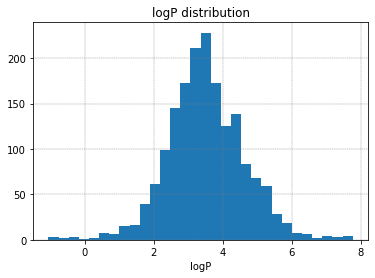

In [28]:
def build_histogram(input, title: str = ''):
    x = input
    n, bins, patches = plt.hist(x, 30)

    #plt.style.use('classic')
    plt.xlabel(title)
    plt.title(f'{title} distribution')
    plt.grid(True, color = "grey", linewidth = "0.4", linestyle = "dashed")
    plt.show()

build_histogram(input=dataset[ASSAY], title=ASSAY)

## Out-of-fold $r^2$ score estimations on train, validation and test datasets

### Random Forest Regression

In [29]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.ensemble import RandomForestRegressor
from utils.folds import oof


bundle = train_test_split(fingerprints, dataset, shuffle=True, random_state=SEED, test_size=0.25)

y_test = bundle[3]

model = RandomForestRegressor(n_estimators=100, max_features=0.2, max_depth=12, min_samples_leaf=2)
errors, y_pred = oof(model, bundle, assay=ASSAY)

MEAN TRAIN:  0.9400152382338234
MEAN VALIDATION:  0.7448080151774217
MEAN TEST 0.7587033849169857


### Static plots

In [30]:
from utils.plots import static_avp_avr_graphs, avr_plot, avp_plot

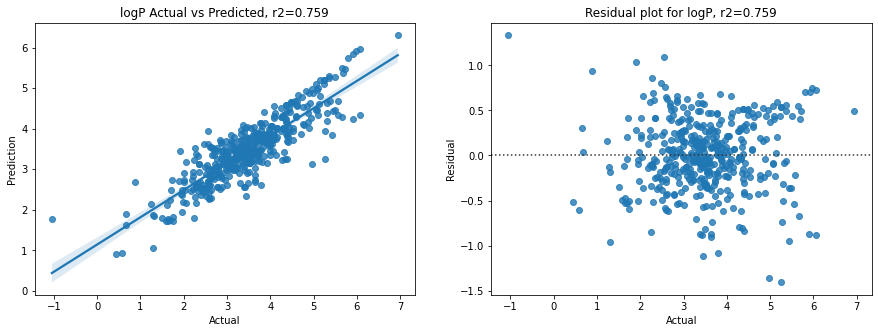

In [31]:
static_avp_avr_graphs(y_pred, y_test[ASSAY], np.mean(errors), ASSAY)

### Interactive plots

In [ ]:
avp_plot(y_test[ASSAY], y_pred, y_test.index.values, y_test["Structure"], np.mean(errors))

In [ ]:
avr = avr_plot(y_test[ASSAY], y_pred, y_test.index.values, y_test["Structure"], np.mean(errors))

### MLP

In [15]:
from utils.mlp import Perceptron


model = Perceptron(input_size=len(fingerprints[0]), lr=5e-3, n_layers=3, batch_size=128, hidden_size=64, n_epochs=1000, p_dropout=0.01)

errors, y_pred = oof(model, bundle, assay=ASSAY)

MEAN TRAIN:  0.9991696141659482
MEAN VALIDATION:  0.8506310432603087
MEAN TEST 0.8608906299433057


### Static plots

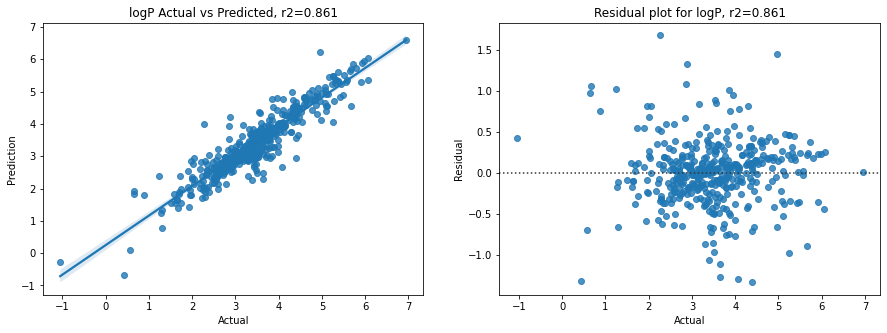

In [19]:
static_avp_avr_graphs(y_pred, y_test[ASSAY], np.mean(errors), title=ASSAY)

### Interactive plots

In [ ]:
avp_plot(y_test[ASSAY], y_pred, y_test.index.values, y_test["Structure"], np.mean(errors))

In [ ]:
avr_plot(y_test[ASSAY], y_pred, y_test.index.values, y_test["Structure"], np.mean(errors))